# Damping value cross validation
The choice of the damping value used in the inversion directly affects the results and therefore needs to be carefully chosen. We provide some tools to perform a cross-validation with a range of damping values in order to chose the optimal value.

This cross validation routine is adapted from [Uieda & Barbosa 2017](https://doi.org/10.1093/gji/ggw390). See their paper for a detailed discussion.

The main idea is to re-sample the gravity data at a finer resolution and separate the data into a `testing` and `training` set. The inversion is performed with a range of damping values, each time using just the `training` set. Each resulting inverted topo from each of the damping values is then forward modelled onto the locations of the `testing` data, which were not included in the inversion. The optimal damping value is the one which results in the smallest difference between the forward modeled data and the `testing` data. 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import verde as vd
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create synthetic data
Below we will create some synthetic topography data to act as the real topography, and it will forward model its gravity effect with some added noise. It will forward model it at 2x the grid spacing to create `testing` and `training` datasets to use for the damping parameter cross validation.

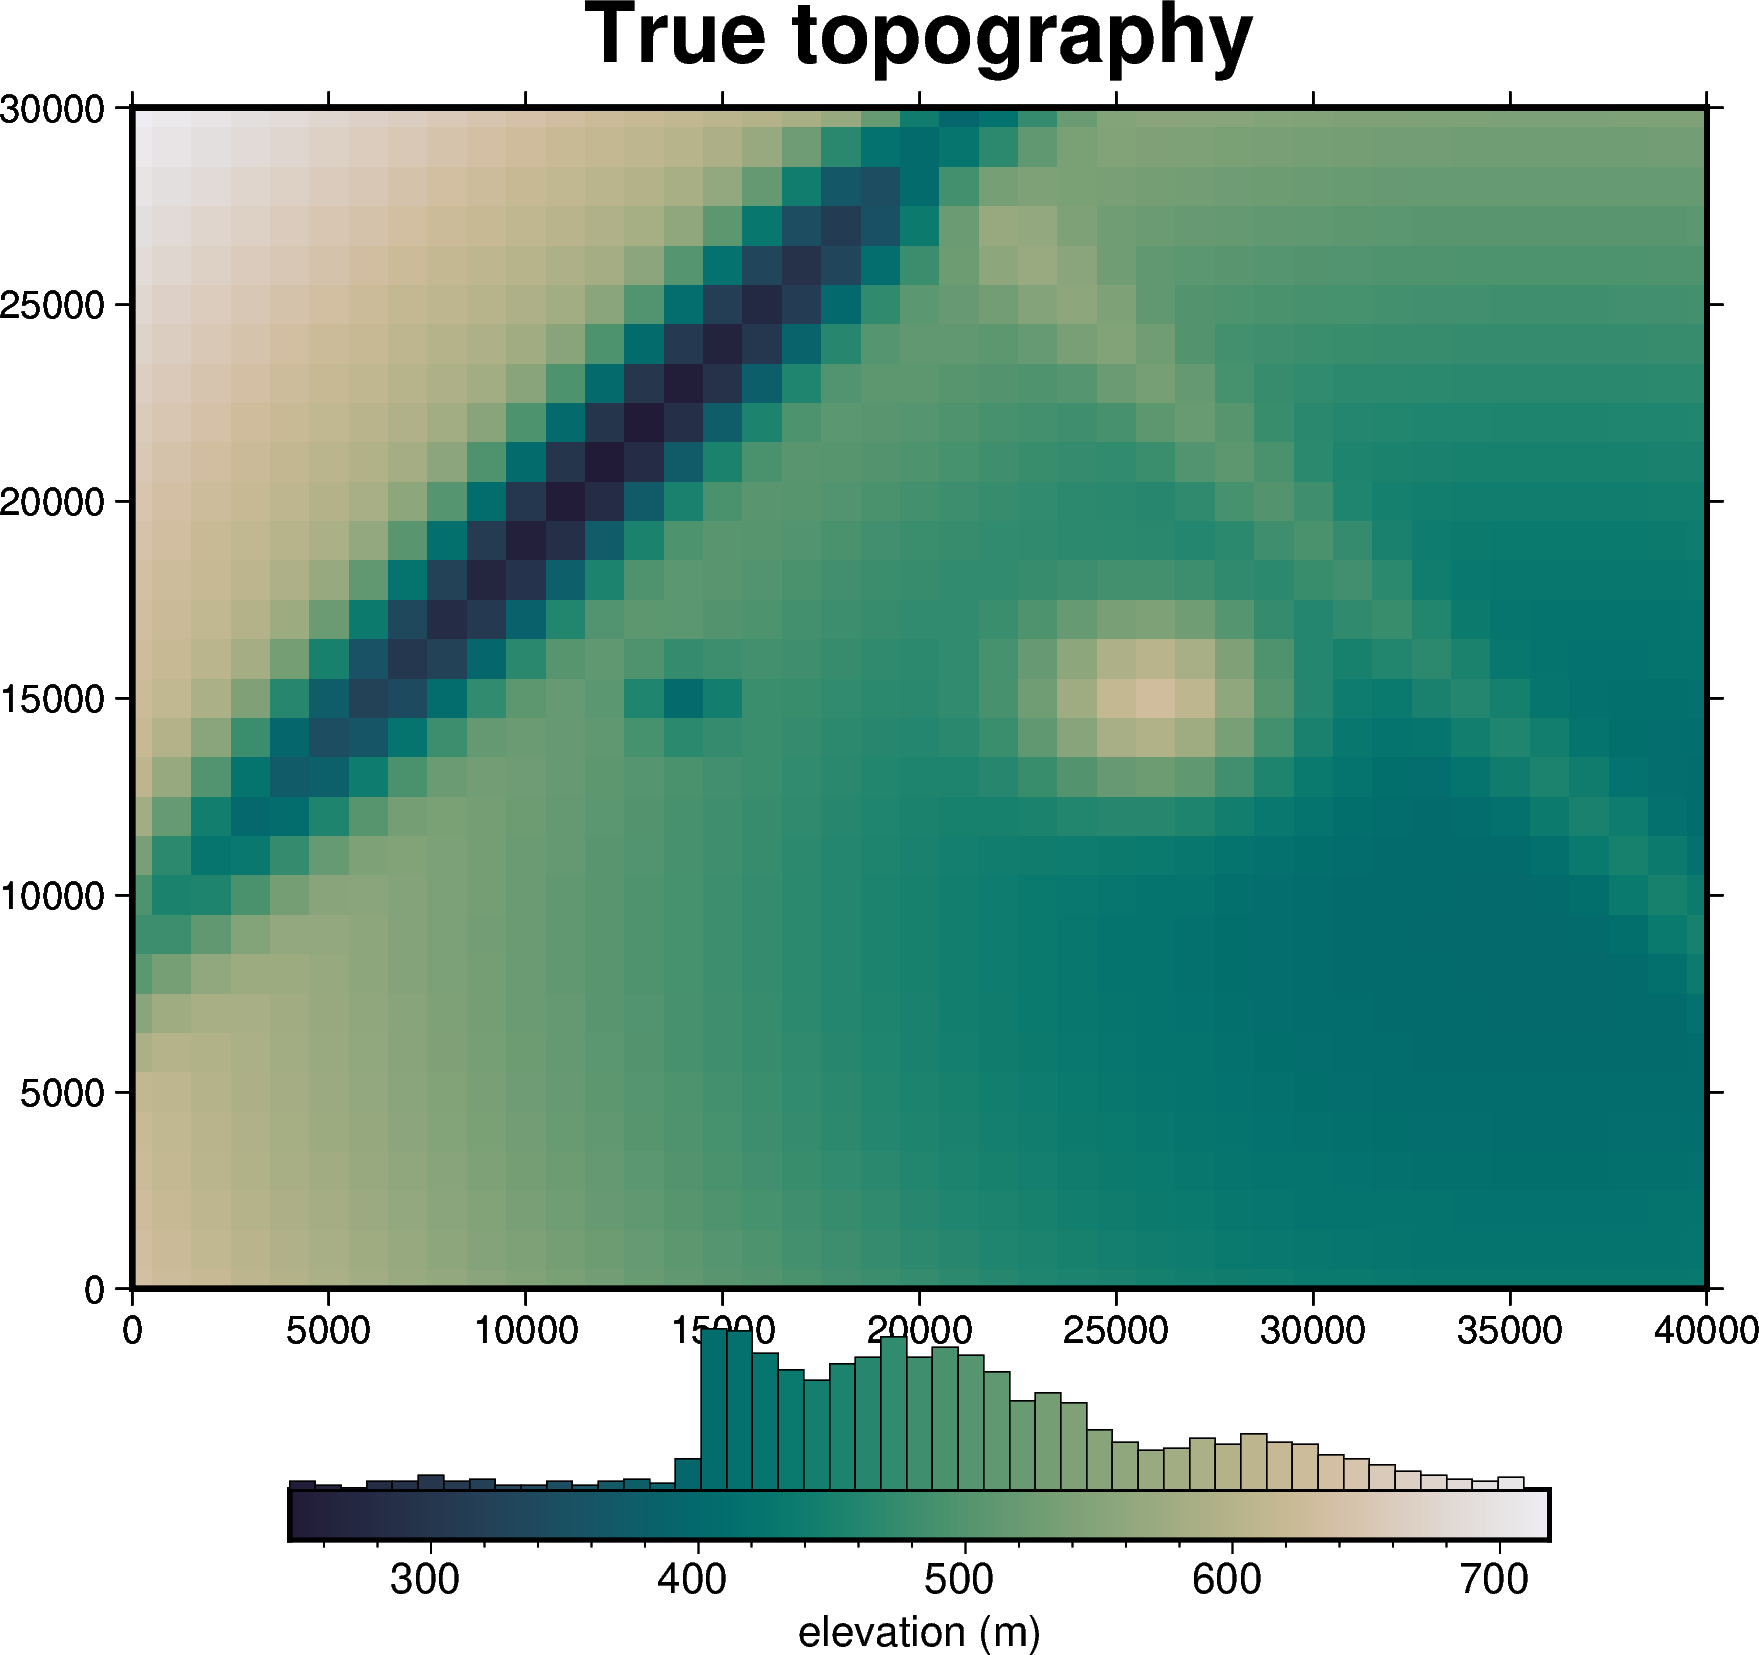

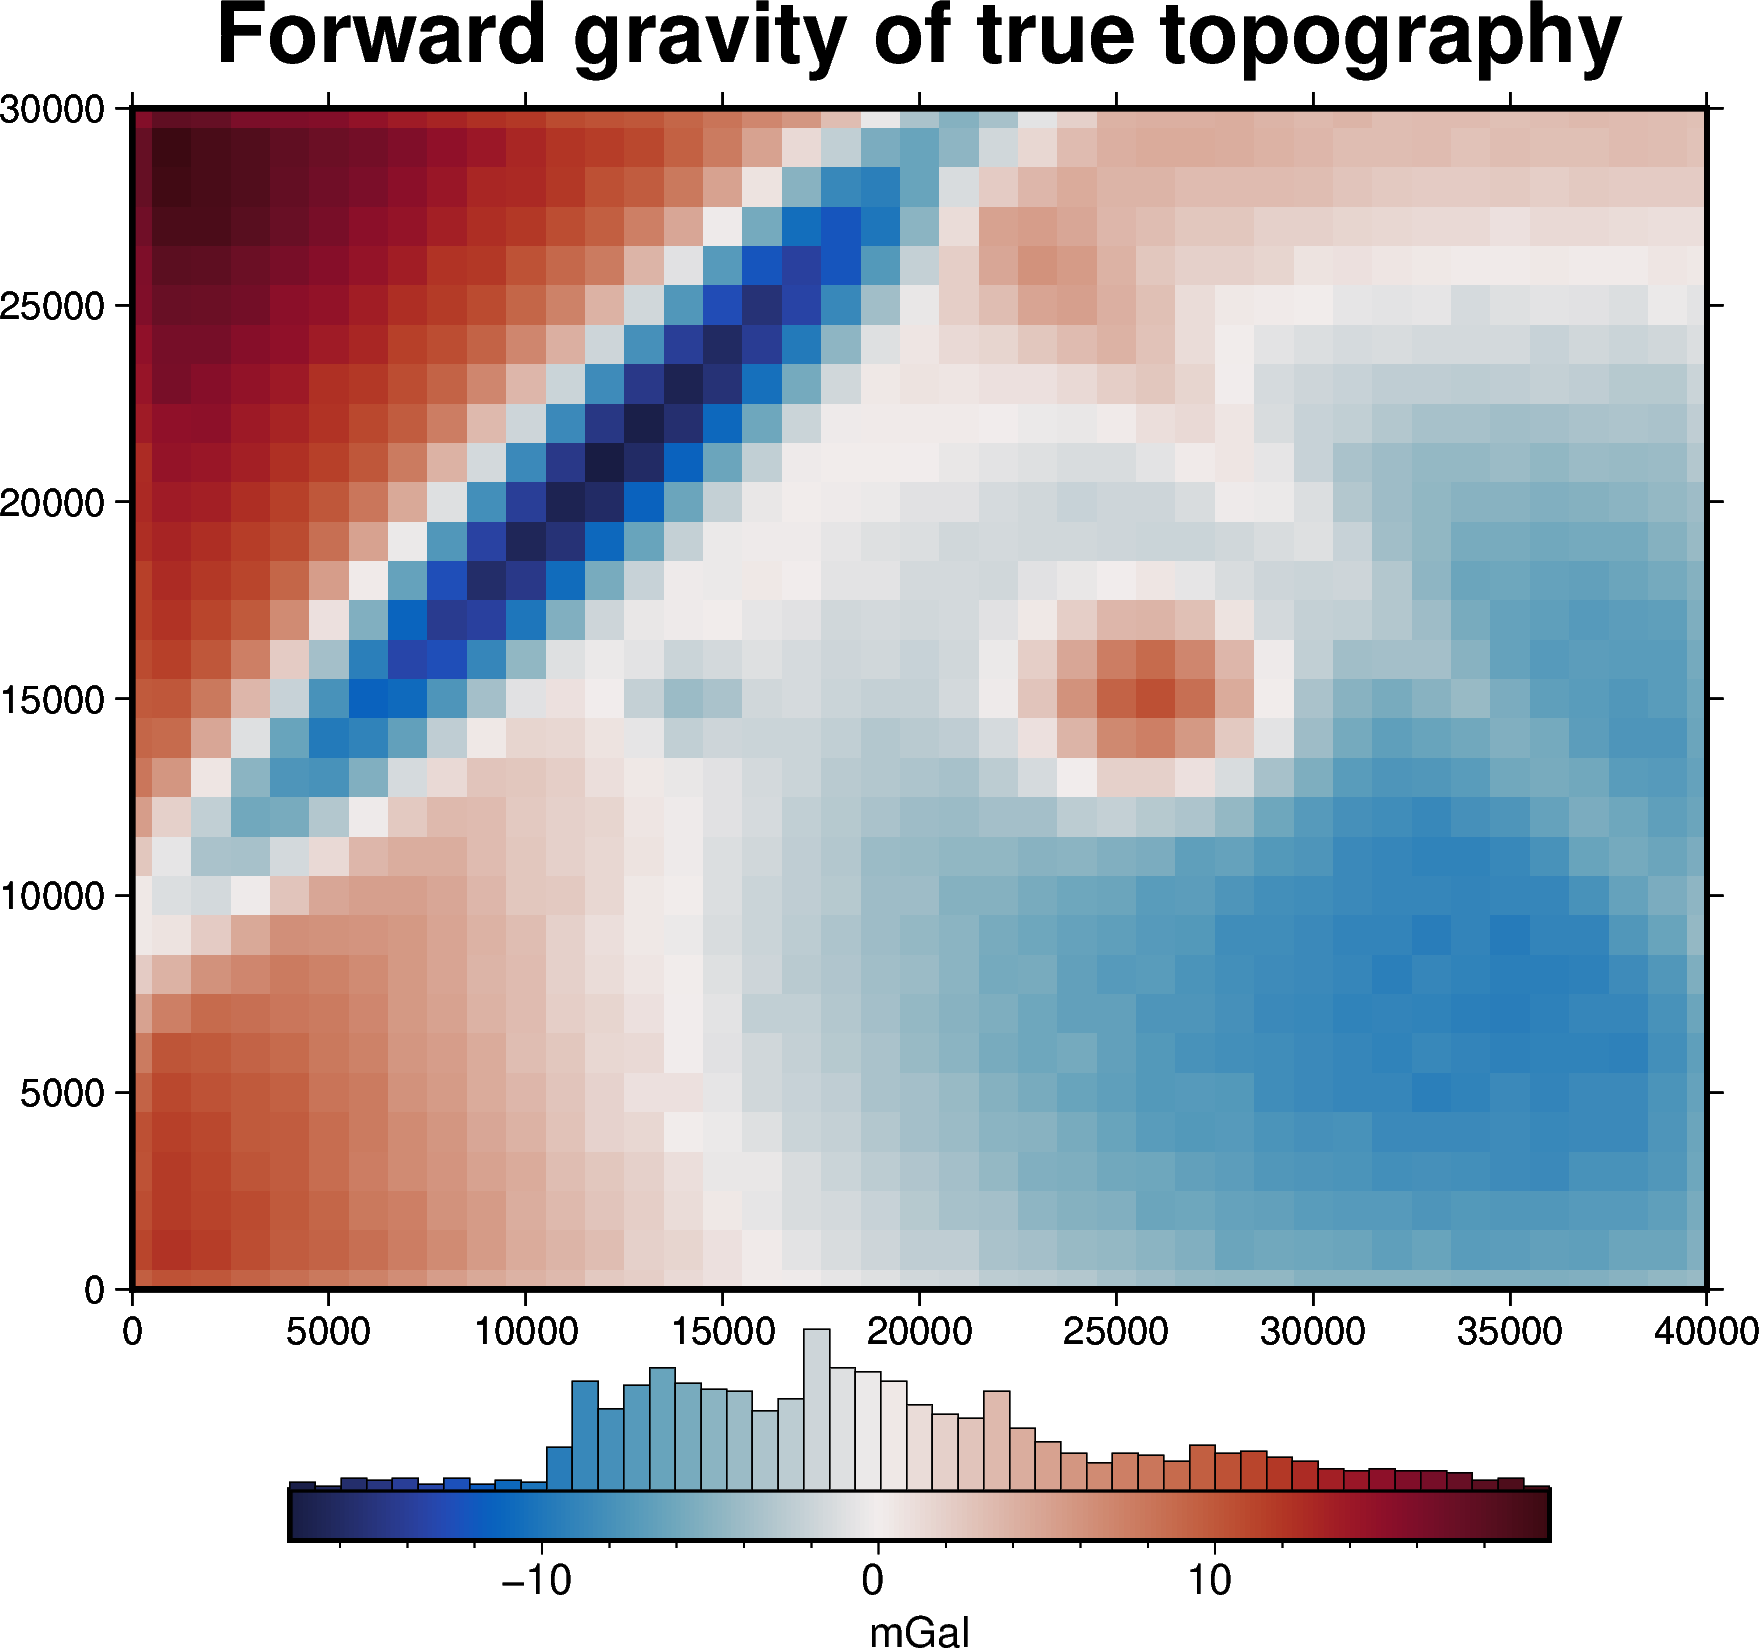

mean of true topography: 492.2704164812973 m 


In [2]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1
true_topography, _, _, observed_gravity = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    density_contrast=true_density_contrast,
    gravity_noise=0.2,
    plot_topography=True,
)
true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

## Gravity misfit

As in the last notebook, for simplicity here we assume that we know the true density contrast and the reference level of the true topography, and use these values to create our starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

In [3]:
data = invert4geom.create_data(observed_gravity)
data

<xarray.Dataset> Size: 21kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.57 10.41 ... 3.12 2.973
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

In [4]:
# make a flat grid at the height of the zref
grid_coords = vd.grid_coordinates(region=data.region, spacing=data.spacing)
starting_topography = vd.make_xarray_grid(
    grid_coords, data=np.ones_like(grid_coords[0]) * true_zref, data_names="upward"
)

In [5]:
model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    starting_topography=starting_topography,
)

In [6]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|          | 0/1271 [00:00<?, ?it/s]

In many cases, we want to remove a regional signal from the misfit to isolate the residual signal. In this simple case, we assume there is no regional misfit and set it to 0. The function below will subtract the column `forward_gravity` from `gravity_anomaly` to create `misfit`. The `reg` column (chosen here to be 0) is then subtracted from `misfit` to get `res`, the residual gravity misfit.

In [7]:
data.inv.regional_separation(
    method="constant",
    constant=0,
)
data

<xarray.Dataset> Size: 102kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
Data variables:
    upward                    (northing, easting) float64 10kB 1e+03 ... 1e+03
    gravity_anomaly           (northing, easting) float64 10kB 9.57 ... 2.973
    forward_gravity           (northing, easting) float64 10kB -0.0 ... -0.0
    misfit                    (northing, easting) float64 10kB 9.57 ... 2.973
    reg                       (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 10kB 9.57 ... 2.973
    starting_forward_gravity  (northing, easting) float64 10kB -0.0 ... -0.0
    starting_misfit           (northing, easting) float64 10kB 9.57 ... 2.973
    starting_reg              (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    starting_res              (northing, easting) float64 10kB 9.57 ... 2.973
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!
makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!


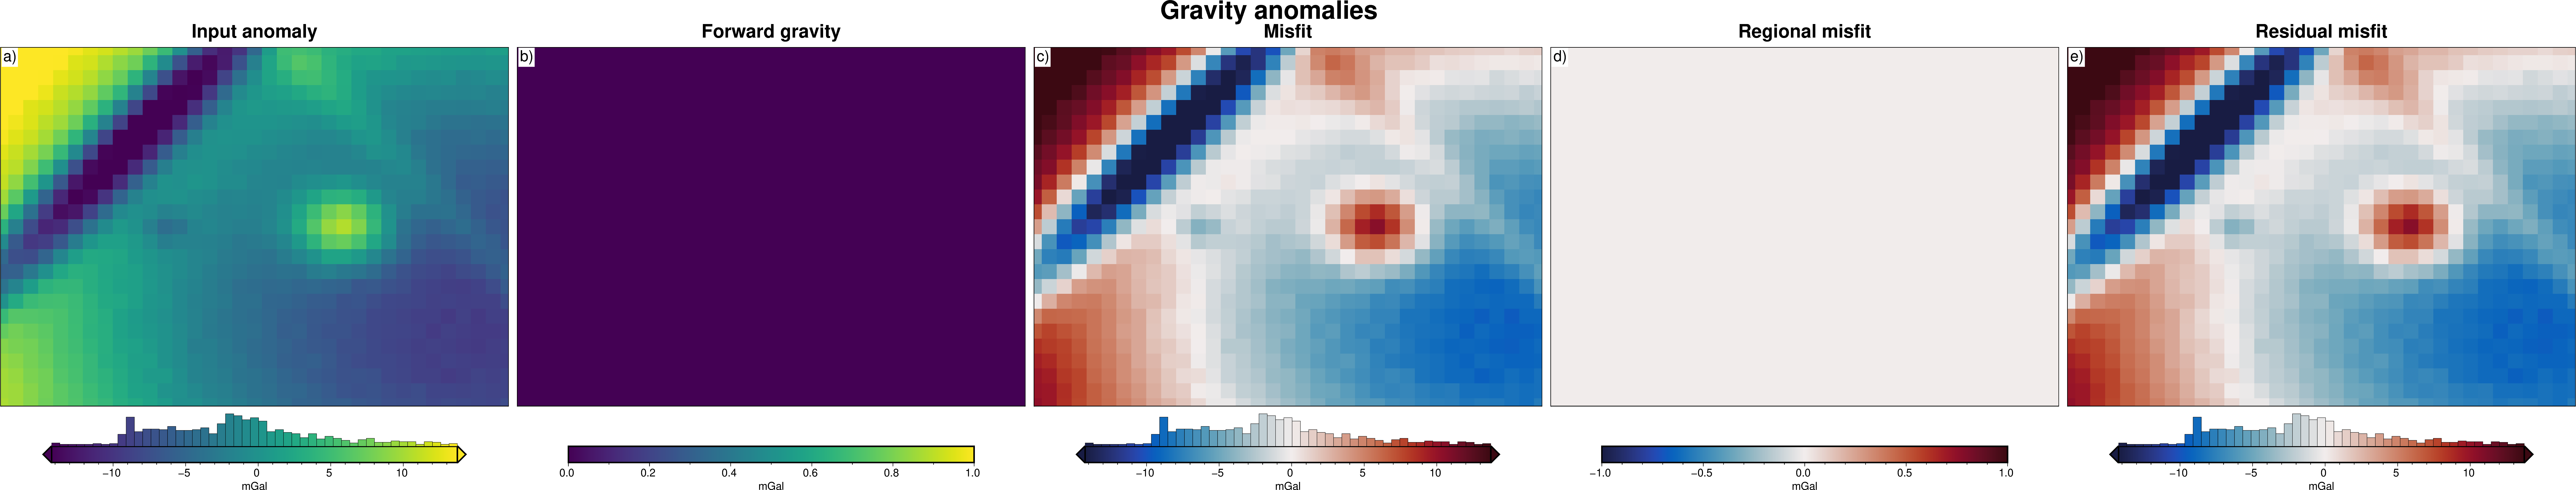

In [8]:
data.inv.plot_anomalies()

## Get Cross Validation Score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

In [9]:
data.inv.df

,northing,easting,upward,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,0.0,0.0,1000.0,9.569727,-0.0,9.569727,0.0,9.569727,-0.0,9.569727,0.0,9.569727
1,0.0,1000.0,1000.0,10.406525,-0.0,10.406525,0.0,10.406525,-0.0,10.406525,0.0,10.406525
2,0.0,2000.0,1000.0,10.088077,-0.0,10.088077,0.0,10.088077,-0.0,10.088077,0.0,10.088077
3,0.0,3000.0,1000.0,9.300146,-0.0,9.300146,0.0,9.300146,-0.0,9.300146,0.0,9.300146
4,0.0,4000.0,1000.0,8.434769,-0.0,8.434769,0.0,8.434769,-0.0,8.434769,0.0,8.434769
...,...,...,...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.117968,-0.0,3.117968,0.0,3.117968,-0.0,3.117968,0.0,3.117968
1267,30000.0,37000.0,1000.0,3.472211,-0.0,3.472211,0.0,3.472211,-0.0,3.472211,0.0,3.472211
1268,30000.0,38000.0,1000.0,3.402659,-0.0,3.402659,0.0,3.402659,-0.0,3.402659,0.0,3.402659
1269,30000.0,39000.0,1000.0,3.120303,-0.0,3.120303,0.0,3.120303,-0.0,3.120303,0.0,3.120303


In [10]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.2**2,  # gravity error is .2 mGal or L2-norm of ~0.45
    delta_l2_norm_tolerance=1.01,
)

# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)
inv.data

<xarray.Dataset> Size: 401kB
Dimensions:                   (northing: 61, easting: 81)
Coordinates:
  * northing                  (northing) float64 488B 0.0 500.0 ... 3e+04
  * easting                   (easting) float64 648B 0.0 500.0 ... 4e+04
Data variables:
    test                      (northing, easting) bool 5kB False True ... False
    upward                    (northing, easting) float64 40kB 1e+03 ... 1e+03
    gravity_anomaly           (northing, easting) float64 40kB 9.57 ... 2.973
    forward_gravity           (northing, easting) float64 40kB 0.0 0.0 ... 0.0
    misfit                    (northing, easting) float64 40kB 9.57 ... 2.973
    reg                       (northing, easting) float64 40kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 40kB 9.57 ... 2.973
    starting_forward_gravity  (northing, easting) float64 40kB 0.0 0.0 ... 0.0
    starting_misfit           (northing, easting) float64 40kB 9.57 ... 2.973
    starting_reg              (northing, easting) float64 40kB 0.0 0.0 ... 0.0
    starting_res              (northing, easting) float64 40kB 9.57 ... 2.973
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

Inversion terminated due to max_iterations limit. Consider increasing this limit.


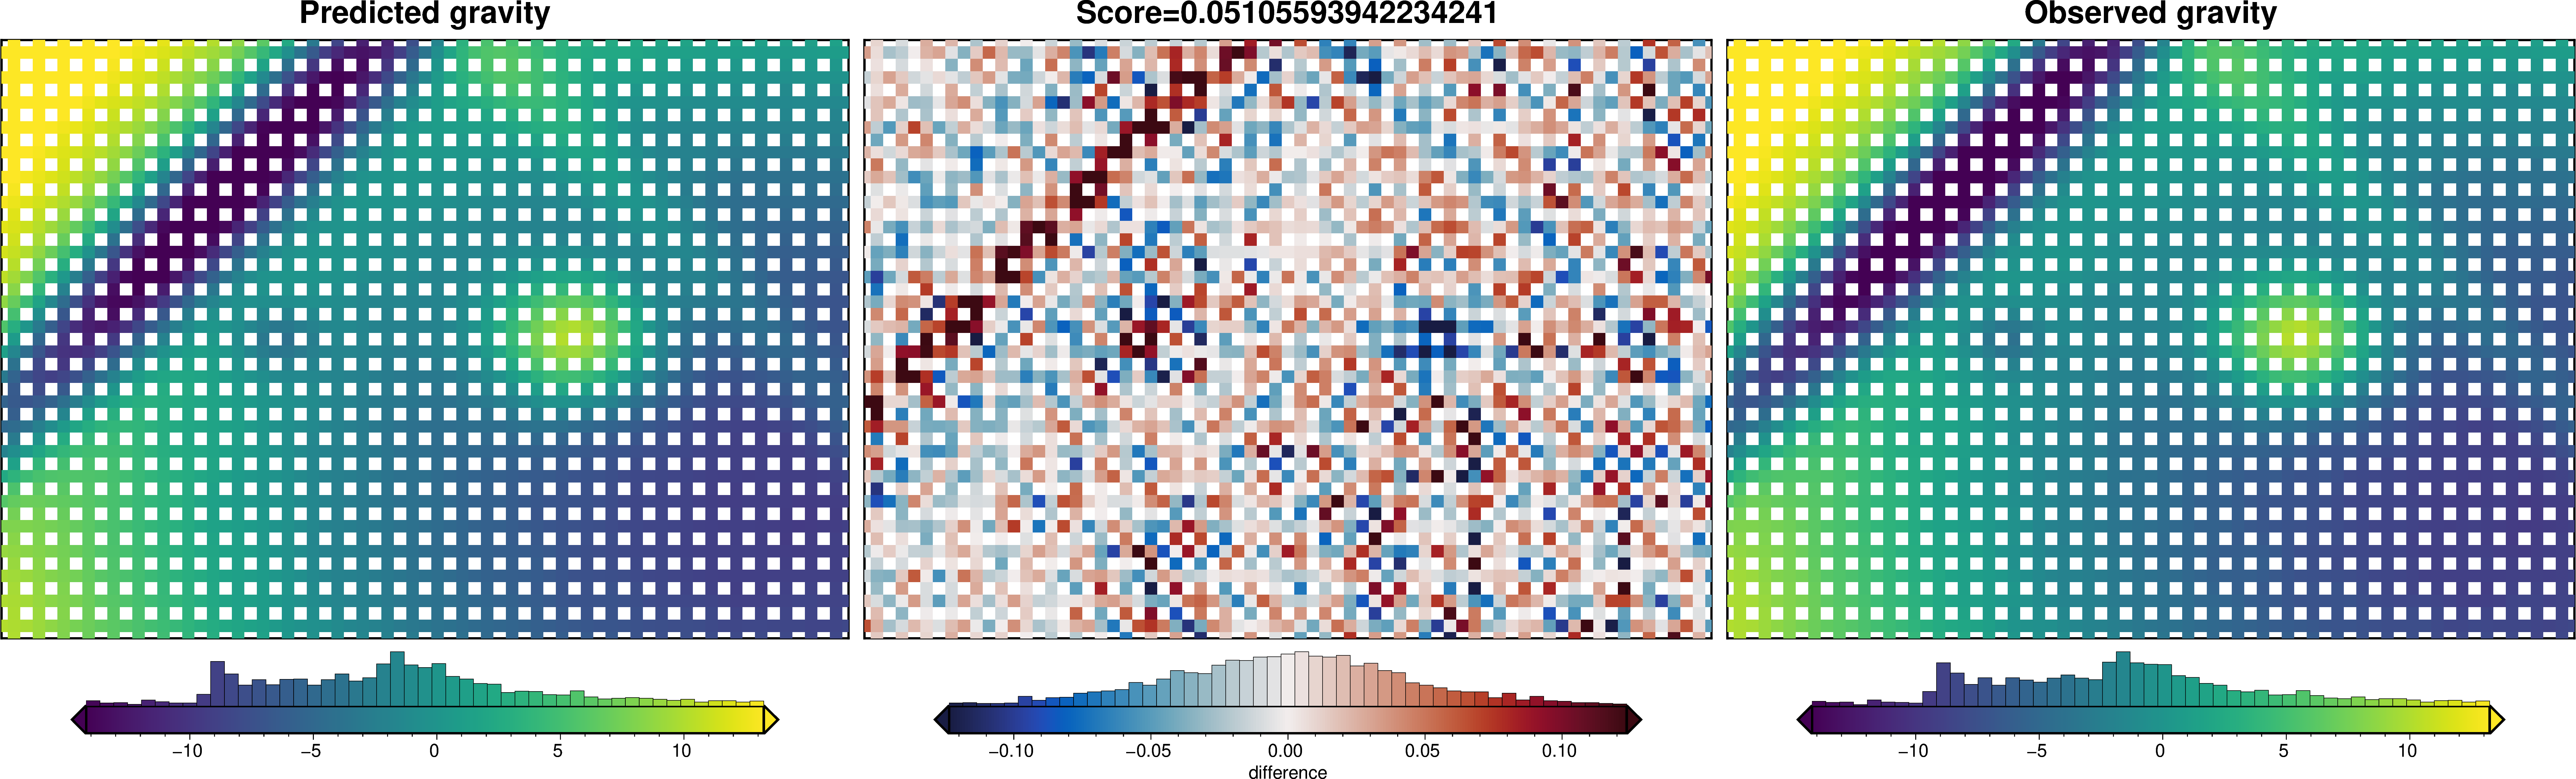

np.float64(0.05105593942234241)

In [11]:
# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
grav_cv_object = inv.gravity_score(
    plot=True,
)
inv.gravity_best_score

## Cross Validation
Now we can repeat this with a range of damping parameters to find the optimal (lowest) score.

This is a classic optimization problem, where we vary the damping parameter to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, [optimize_inversion_damping](../api/generated/invert4geom.Inversion.optimize_inversion_damping.rst) will use a sampler to choose damping values between the provided `damping_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test damping values at a constant interval, you can set `grid_search` to True, and this will test all damping values as defined by:

```python
np.logspace(<<exponent of lower damping limit>>, <<exponent of upper damping limit>>, n_trials)
```

In [12]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    grid_search=True,
    plot_scores=False,
    fname="../tmp/04_damping_CV",
)
inv.solver_damping

  0%|          | 0/8 [00:00<?, ?it/s]

Inversion terminated due to max_iterations limit. Consider increasing this limit.


np.float64(0.019306977288832496)

In [15]:
damping_cv_obj.study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_damping,user_attrs_fname,system_attrs_grid_id,system_attrs_search_space,state
0,0,1.731974,2025-11-12 13:45:48.934225,2025-11-12 13:46:07.350464,0 days 00:00:18.416239,0.372759,../tmp/04_damping_CV_trial_0,0,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
1,1,0.120580,2025-11-12 13:46:07.352521,2025-11-12 13:46:10.711768,0 days 00:00:03.359247,0.007197,../tmp/04_damping_CV_trial_1,1,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
2,2,0.812554,2025-11-12 13:46:10.714760,2025-11-12 13:46:12.826325,0 days 00:00:02.111565,0.002683,../tmp/04_damping_CV_trial_2,2,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
3,3,6.319642,2025-11-12 13:46:12.827501,2025-11-12 13:46:13.903552,0 days 00:00:01.076051,1.000000,../tmp/04_damping_CV_trial_3,3,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
4,4,0.023230,2025-11-12 13:46:13.904812,2025-11-12 13:46:26.375126,0 days 00:00:12.470314,0.019307,../tmp/04_damping_CV_trial_4,4,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
5,5,0.890006,2025-11-12 13:46:26.376448,2025-11-12 13:46:28.358623,0 days 00:00:01.982175,0.001000,../tmp/04_damping_CV_trial_5,5,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
6,6,0.097875,2025-11-12 13:46:28.359806,2025-11-12 13:46:42.107012,0 days 00:00:13.747206,0.138950,../tmp/04_damping_CV_trial_6,6,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE
7,7,0.026467,2025-11-12 13:46:42.108285,2025-11-12 13:46:56.780557,0 days 00:00:14.672272,0.051795,../tmp/04_damping_CV_trial_7,7,"{'damping': [0.001, 0.0026826957952797246, 0.0...",COMPLETE


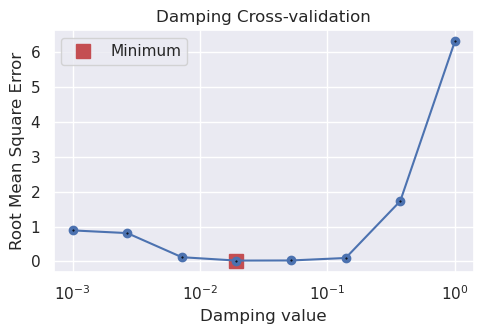

In [16]:
fig = invert4geom.plot_scores(
    damping_cv_obj.study.trials_dataframe().value.values,
    damping_cv_obj.study.trials_dataframe().params_damping.values,
    param_name="Damping",
    logx=True,
)

## Plot inversion results using optimal value

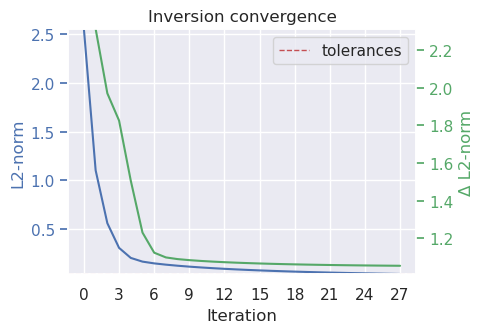

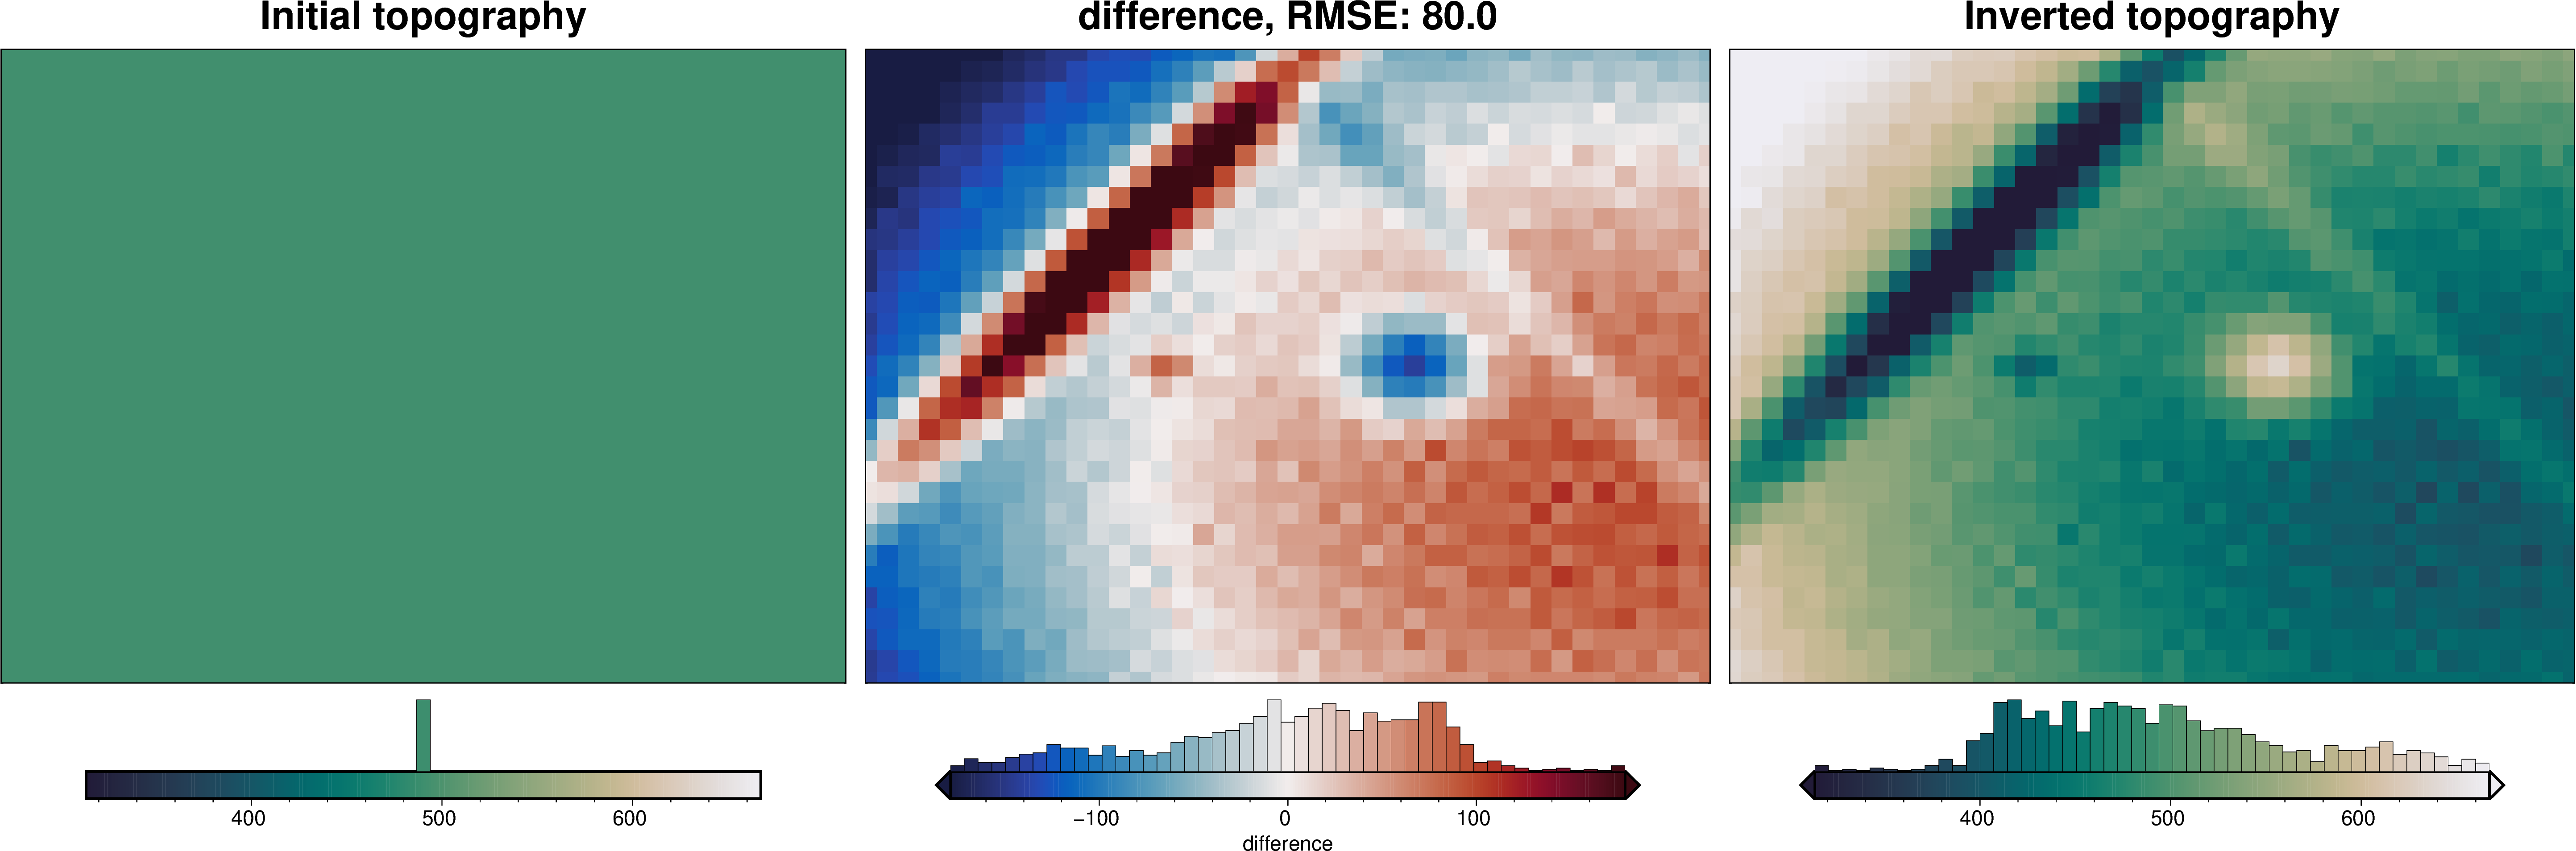

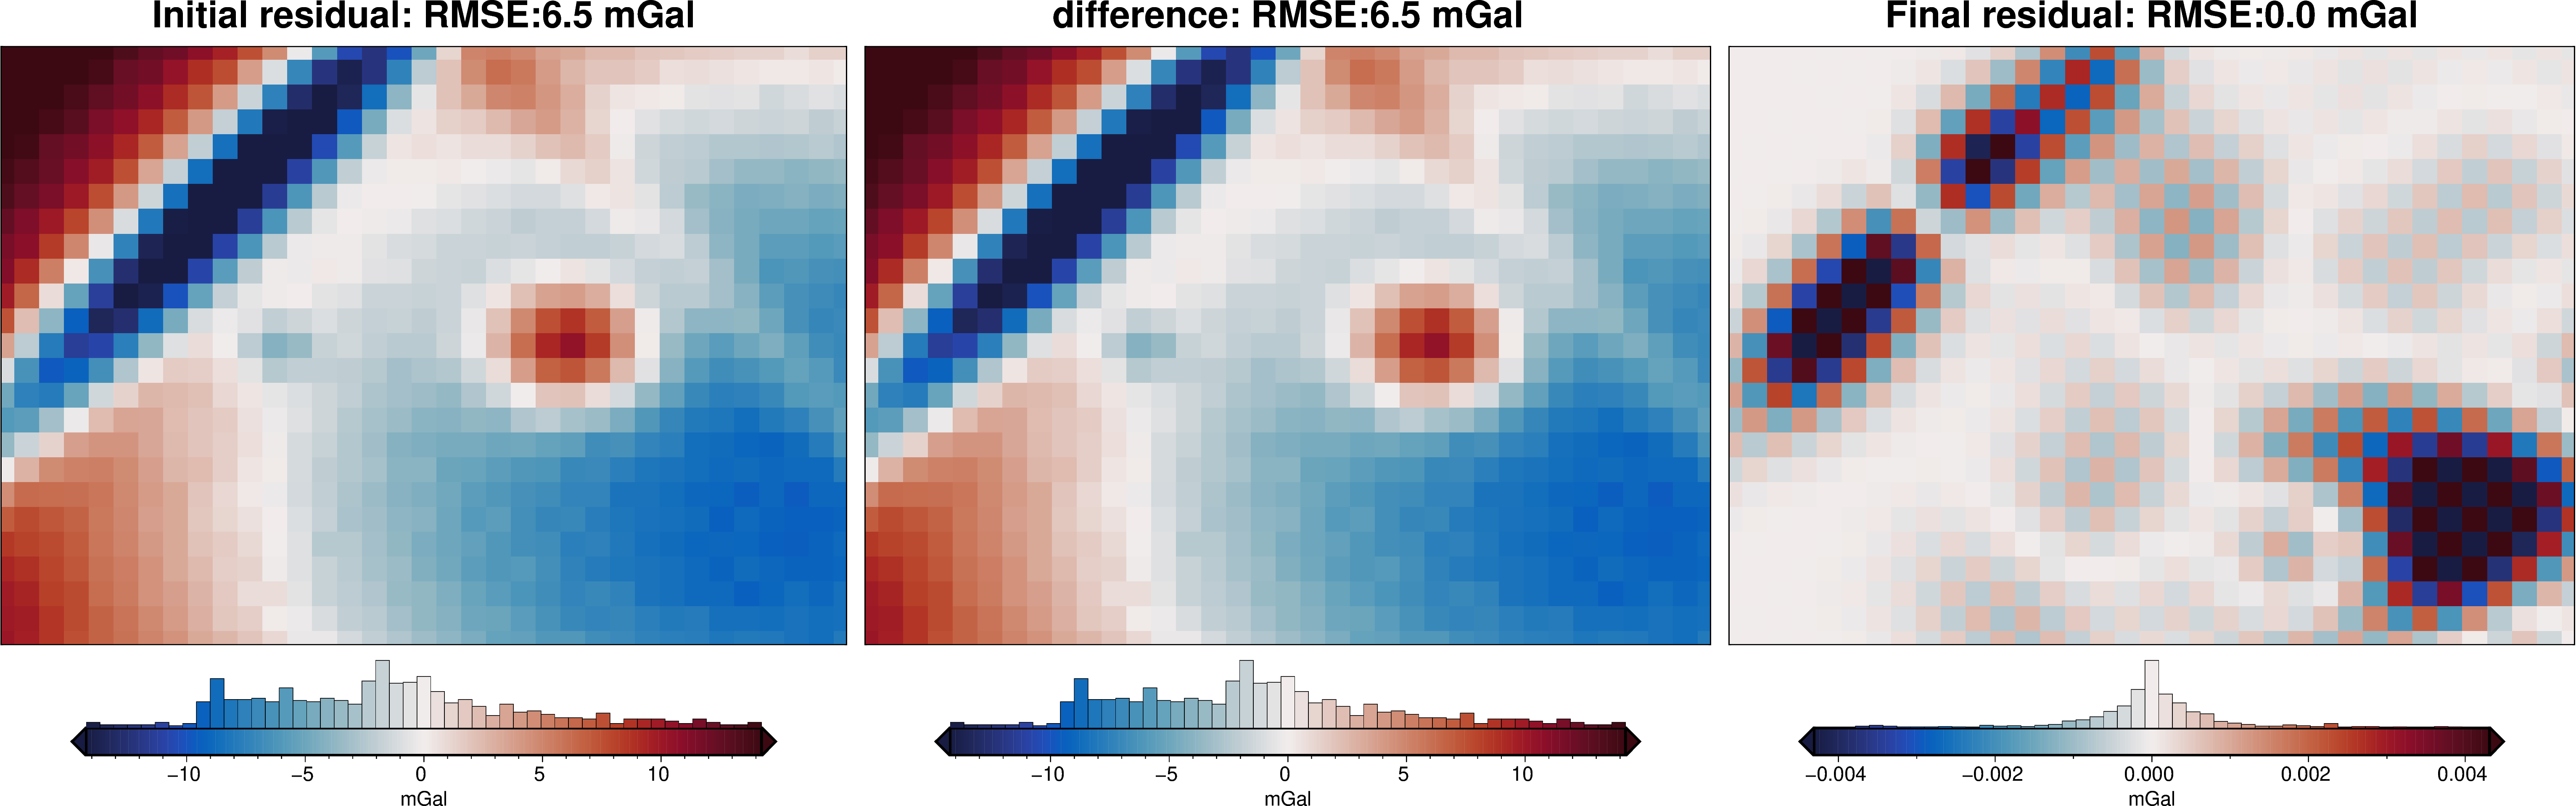

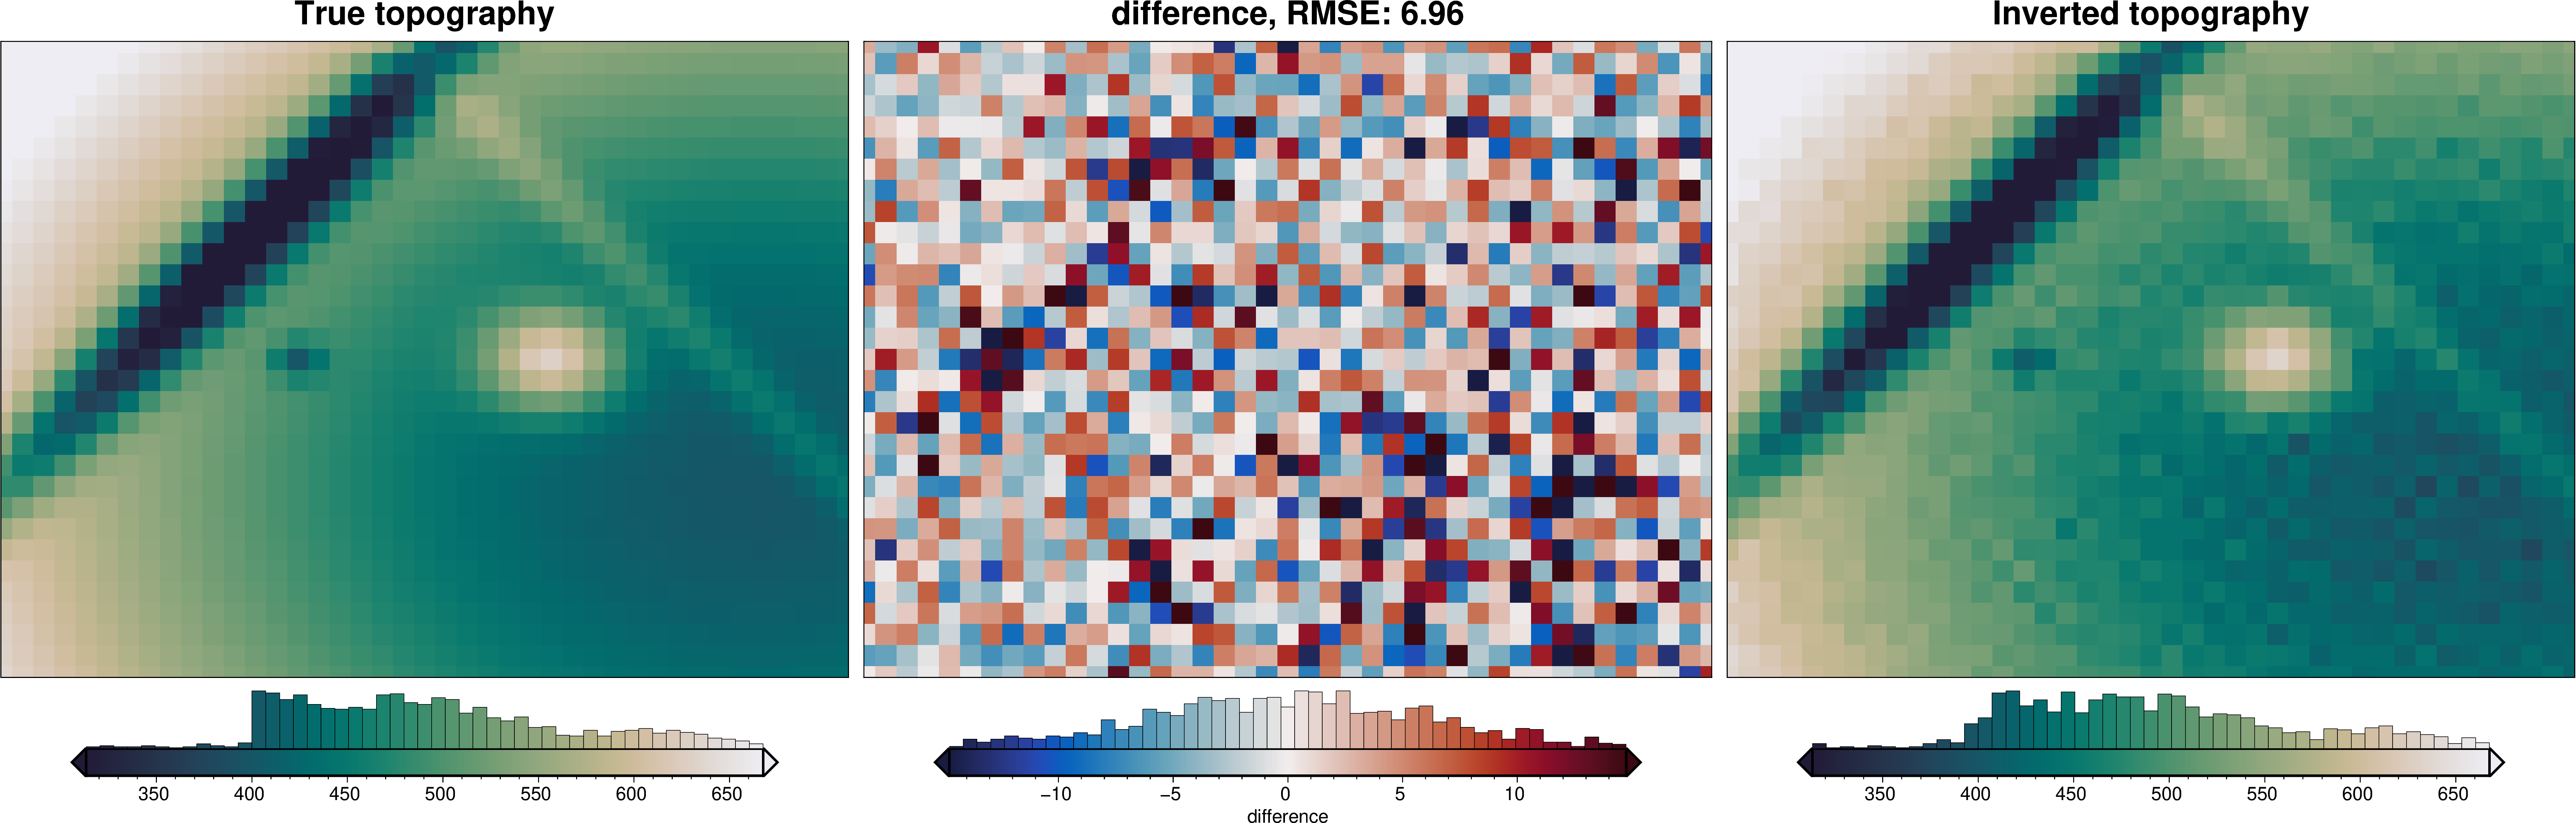

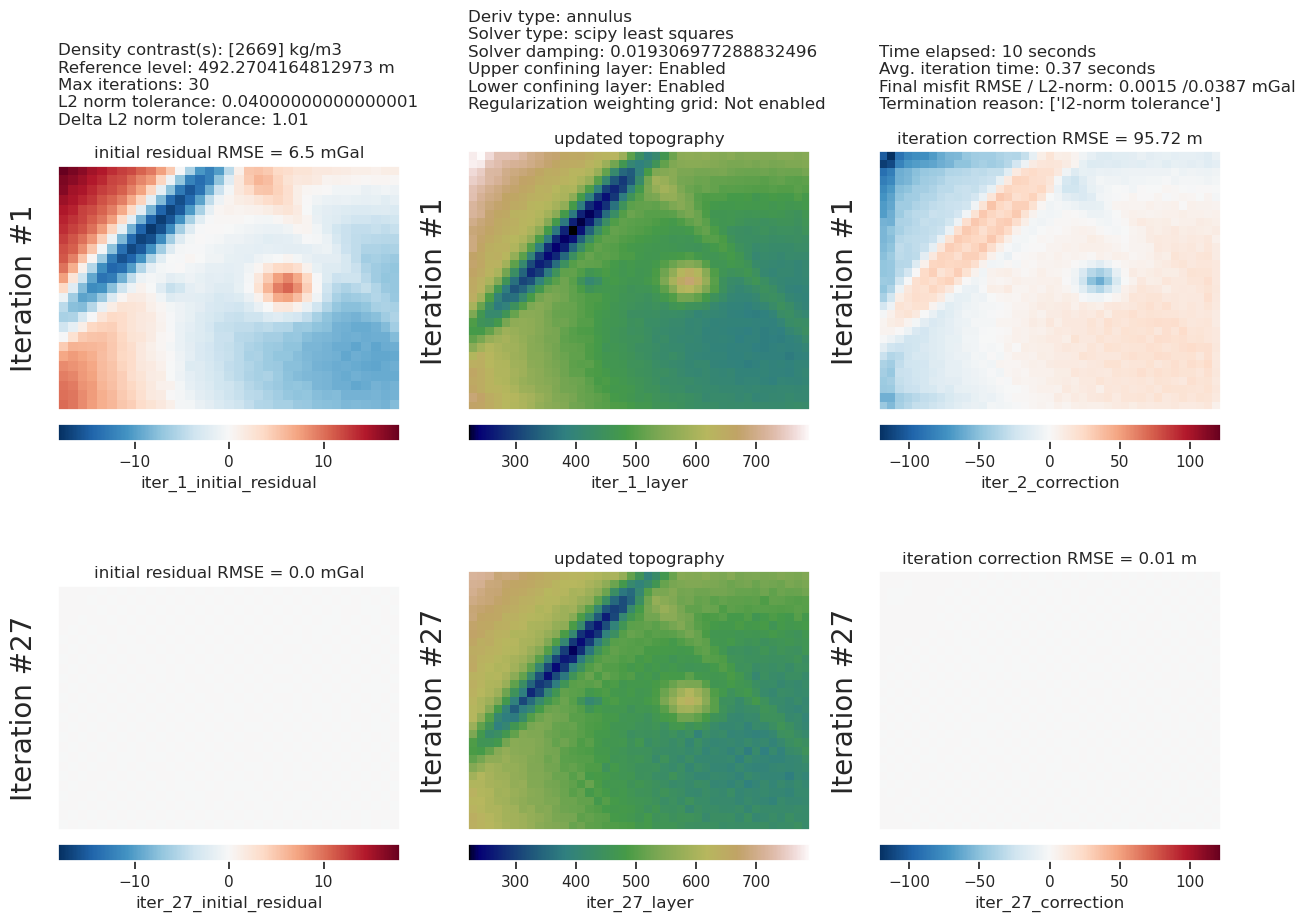

In [ ]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
)

## Run inversion with poor choice of damping value

In [15]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.005,
    # set stopping criteria
    l2_norm_tolerance=0.2**2,  # gravity error is .2 mGal or L2-norm of ~0.45
    delta_l2_norm_tolerance=1.01,
)

inv.invert()

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

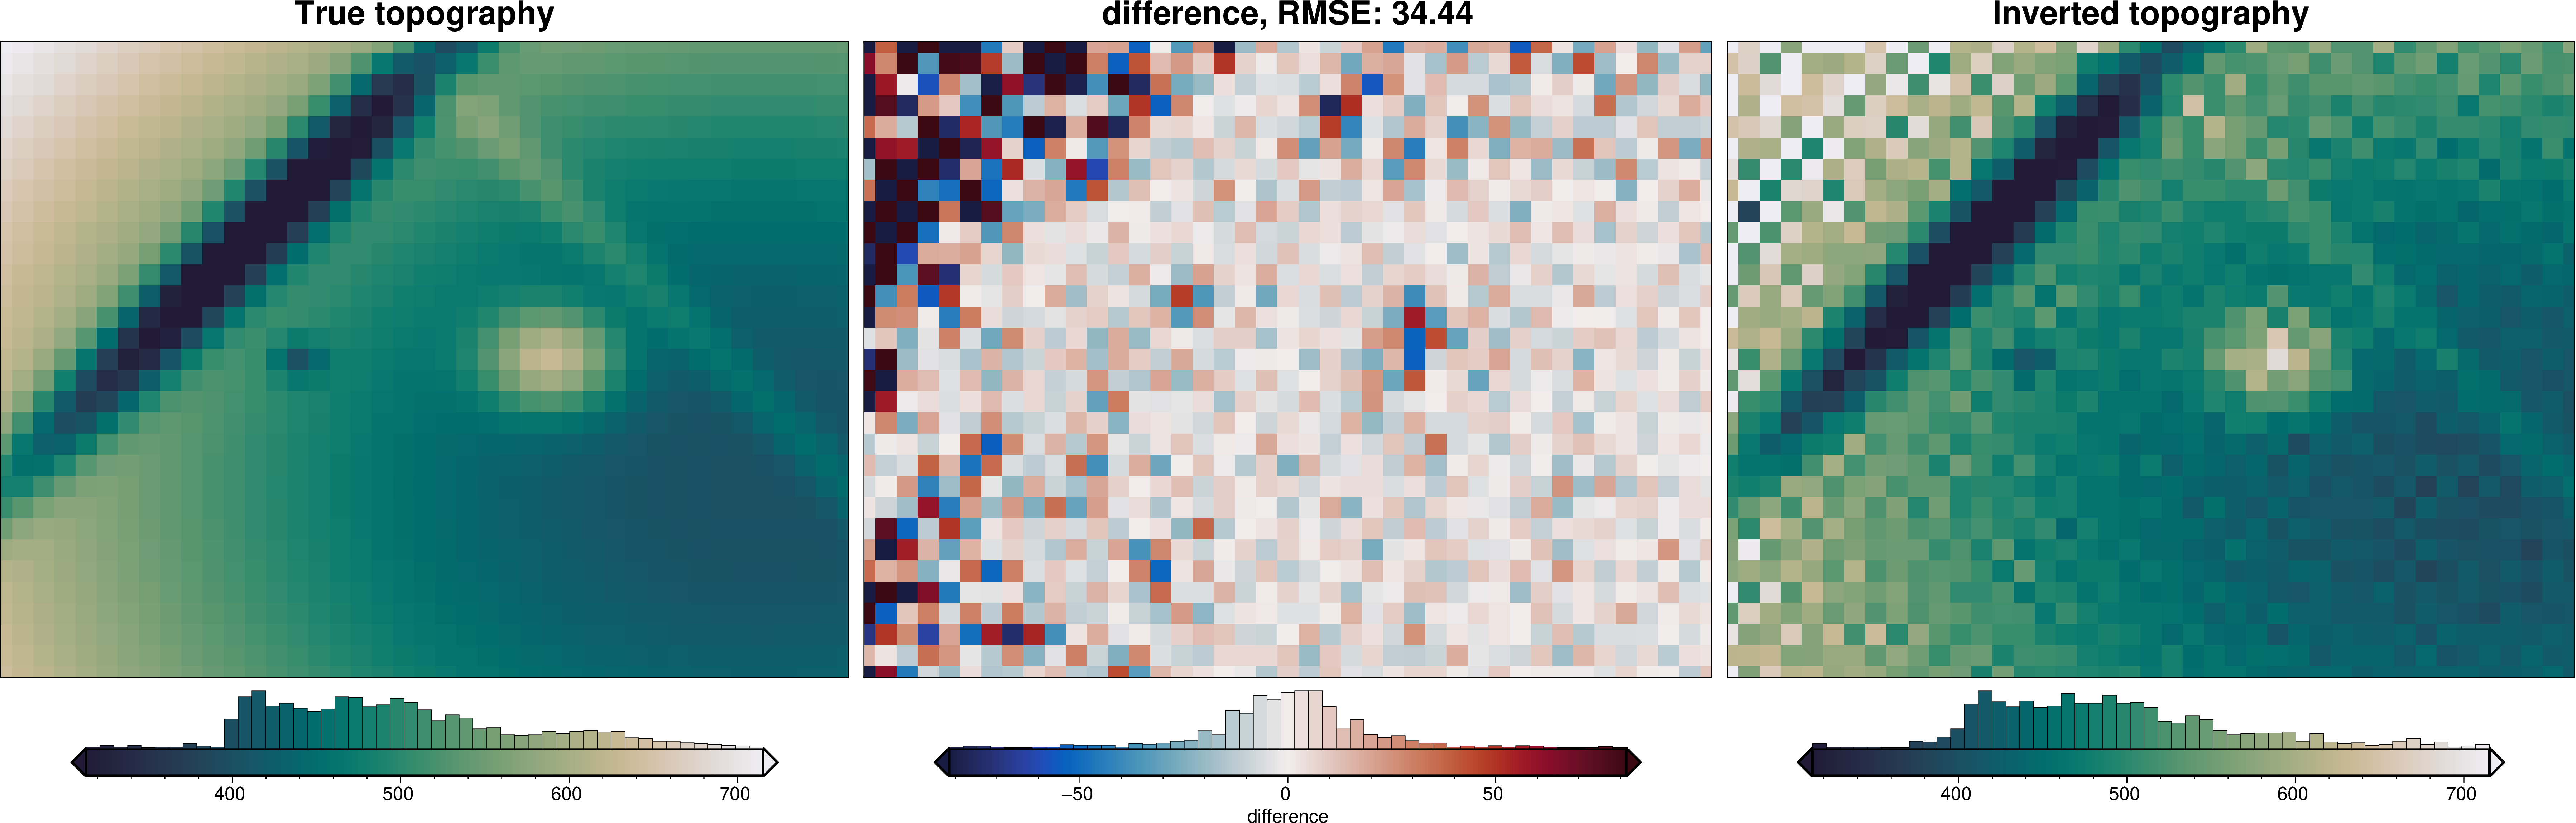

In [ ]:
_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
)

Comparing this inversion with a damping value of 0.005 to the inversion with the optimal damping value of ~0.1 shows that a low damping value allows too much noise through to the final inverted topography. 

In the past example ([simple inversion](02_simple_inversion.ipynb)), we arbitrarily chose a damping value. Here, we show how by finding the optimal damping value using a cross-validation, we have improved the inversion's performance.

The next notebook, [density optimization](05_density_optimization.ipynb), will show how to perform a similar procedure for choosing a density contrast value.

#